Thanks to https://www.kaggle.com/cdeotte/data-without-drift.

Thanks to https://www.kaggle.com/ragnar123/clean-kalman #Clean data with kelman Filter


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tensorflow==1.14
B_NUM = 10
B_SIZE = 500000

     |████████████████████████████████| 109.2MB 39kB/s 
     |████████████████████████████████| 491kB 56.3MB/s 
     |████████████████████████████████| 3.2MB 50.8MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# imports
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
from keras.models import Model
import keras.layers as L
import lightgbm as lgb
from keras.layers import LeakyReLU
from scipy import fftpack
import librosa
import tensorflow as tf


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a

./drive/My Drive/Colab Notebooks/liverpool-ion-switching/music_feature.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission_unshifted_70p.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/a-signal-processing-approach-low-pass-filtering.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/3-simple-ideas-lb-0-938.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/use_sound_feature.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission_XGBoost.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/simple_Boosting.ipynb
./drive/My Drive/Colab Notebooks/liverpool

In [4]:
tf.__version__

'1.14.0'

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [6]:
kal_data = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean_kalman.csv')
data = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean.csv')
# data = data[B_SIZE:2*B_SIZE]
# data.reset_index(inplace=True)
# data.drop('index', axis=1, inplace=True)
data

,time,signal,open_channels
0,0.0001,-2.760000,0
1,0.0002,-2.855700,0
2,0.0003,-2.407400,0
3,0.0004,-3.140400,0
4,0.0005,-3.152500,0
...,...,...,...
4999995,499.9996,2.932577,7
4999996,499.9997,2.711208,7
4999997,499.9998,4.529640,8
4999998,499.9999,5.652972,9


**Feature Engineering**: Thanks to  https://www.kaggle.com/martxelo/fe-and-simple-mlp 

In [0]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [0]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [0]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [0]:
def calc_roll_stats(s, windows=[5, 10, 50, 100, 500, 1000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        r = s.rolling(window=w, min_periods=1, center=True)
        roll_stats['roll_mean_' + str(w)] = r.mean()
        roll_stats['roll_std_' + str(w)] = r.std()
        roll_stats['roll_min_' + str(w)] = r.min()
        roll_stats['roll_max_' + str(w)] = r.max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_median_' + str(w)] = r.median()
        # roll_stats['roll_skew_' + str(w)] = r.skew()
        # roll_stats['roll_q10_' + str(w)] = r.quantile(0.10)
        # roll_stats['roll_q25_' + str(w)] = r.quantile(0.25)
        # roll_stats['roll_q50_' + str(w)] = r.quantile(0.50)
        # roll_stats['roll_q75_' + str(w)] = r.quantile(0.75)
        # roll_stats['roll_q90_' + str(w)] = r.quantile(0.90)
        # roll_stats['roll_agg_sum' + str(w)] = r.aggregate(np.sum)
        # roll_stats['roll_agg_mean' + str(w)] = r.aggregate(np.mean)
        # roll_stats['roll_agg_std' + str(w)] = r.aggregate(np.std)
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [0]:
def calc_ewm(s, windows=[5, 10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        e = s.ewm(span=w, min_periods=1)
        ewm['ewm_mean_' + str(w)] = e.mean()
        ewm['ewm_std_' + str(w)] = e.std()

        # ewm['ewm_agg_mean' + str(w)] = e.aggregate(np.mean)
        # ewm['ewm_agg_std' + str(w)] = e.aggregate(np.std)
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [0]:
# get lead and lags features
def lag_with_pct_change(s, windows):
    shift = pd.DataFrame()
    for window in windows:    
        shift['signal_shift_pos_' + str(window)] = s.shift(window).fillna(0)
        shift['signal_shift_neg_' + str(window)] = s.shift(-1 * window).fillna(0)
    return shift

In [0]:
def calc_mfcc(s, windows=[256]):

  mfcc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    mfcc_ = librosa.feature.mfcc(y=s.values, n_mfcc=12, sr=96000, hop_length=window, n_fft=window, n_mels=int(window/16))
    mfcc_lists = []
    for i in range(len(mfcc_[0])):
      mfcc_list = [mfcc_[0][i]] * window
      mfcc_lists.extend(mfcc_list)
    # mfcc['signal_mfcc_' + str(window)] = mfcc_lists[:500000]
  # print(len(mfcc))

  return mfcc_lists

In [25]:
test = data.signal[0:50000]
mfcc = calc_mfcc(test)
len(mfcc)

50176

In [0]:
def calc_zerocross(s, windows=[500]):

  zc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    zc_ = librosa.feature.zero_crossing_rate(y=s.values, frame_length=window, hop_length=window)
    zc_lists = []
    for i in range(len(zc_[0])):
      zc_list = [zc_[0][i]] * window
      zc_lists.extend(zc_list)
    zc['signal_zc_' + str(window)] = zc_lists[:500000]

  # print(len(zc_[0]))

  return zc

In [0]:
def add_features(s):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    shift = lag_with_pct_change(s, [1, 2, 3])
    mfcc = calc_mfcc(s)
    zc = calc_zerocross(s)
    # agg = calc_agg(s)
    # fft_ = calc_fft(s)
    # print('ewm = ', len(fft_))
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm, shift, mfcc], axis=1)


def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
        # break
    
    return pd.concat(ls, axis=0)

In [0]:
# apply every feature to data
kal_df = divide_and_add_features(kal_data['signal'])
df = divide_and_add_features(data['signal'])

feats= []
for feat in kal_df.columns :
  feats.append('kal_' + feat)
kal_df.columns = feats

df = pd.concat([df, kal_df], axis=1) 

df

100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,kal_roll_mean_100,kal_roll_std_100,kal_roll_min_100,kal_roll_max_100,kal_roll_range_100,kal_roll_median_100,kal_roll_mean_500,kal_roll_std_500,kal_roll_min_500,kal_roll_max_500,kal_roll_range_500,kal_roll_median_500,kal_roll_mean_1000,kal_roll_std_1000,kal_roll_min_1000,kal_roll_max_1000,kal_roll_range_1000,kal_roll_median_1000,kal_ewm_mean_5,kal_ewm_std_5,kal_ewm_mean_10,kal_ewm_std_10,kal_ewm_mean_50,kal_ewm_std_50,kal_ewm_mean_100,kal_ewm_std_100,kal_ewm_mean_500,kal_ewm_std_500,kal_ewm_mean_1000,kal_ewm_std_1000,kal_signal_shift_pos_1,kal_signal_shift_neg_1,kal_signal_shift_pos_2,kal_signal_shift_neg_2,kal_signal_shift_pos_3,kal_signal_shift_neg_3,kal_signal_mfcc_128,kal_signal_mfcc_256,kal_signal_mfcc_512,kal_signal_mfcc_1024
0,-0.184000,-0.006380,0.018133,-0.019688,0.001474,-0.184000,-0.186104,-0.184000,-0.186360,-0.184000,-0.186120,-0.184000,-0.185478,-0.184000,-0.184756,-0.184000,-0.184241,-0.184000,-0.184021,-0.184000,-0.183990,-0.184000,-0.183999,-0.184000,-0.184000,1.665335e-16,0.002104,-1.110223e-16,0.002359,8.326673e-17,0.001995,5.551115e-17,0.001215,0.000000,0.000477,0.000000,0.000080,0.000000,-0.000011,0.000000,...,-0.188017,0.016353,-0.213321,-0.137279,0.076042,-0.188326,-0.181483,0.016220,-0.222829,-0.137279,0.085550,-0.181864,-0.180648,0.016165,-0.224484,-0.137279,0.087204,-0.179991,-0.184044,0.000000,-0.184044,0.000000,-0.184044,0.000000,-0.184044,0.000000,-0.184044,0.000000,-0.184044,0.000000,0.000000,-0.189869,0.000000,-0.161623,0.000000,-0.208669,-114.275999,-151.040156,-191.806005,-239.900652
1,-0.190380,0.011753,-0.001555,-0.018214,0.013497,-0.184099,-0.186085,-0.184151,-0.186375,-0.184231,-0.186187,-0.184350,-0.185620,-0.184525,-0.185014,-0.184779,-0.184664,-0.185137,-0.184534,-0.185627,-0.184120,-0.186287,-0.182812,-0.187196,-0.181310,-6.281325e-03,-0.004295,-6.221075e-03,-0.004001,-6.125474e-03,-0.004303,-5.975875e-03,-0.004989,-0.005747,-0.005571,-0.005405,-0.005796,-0.004913,-0.006066,-0.004224,...,-0.188099,0.016199,-0.213321,-0.137279,0.076042,-0.189869,-0.181515,0.016195,-0.222829,-0.137279,0.085550,-0.181939,-0.180645,0.016149,-0.224484,-0.137279,0.087204,-0.179980,-0.187539,0.004119,-0.187248,0.004119,-0.187015,0.004119,-0.186985,0.004119,-0.186962,0.004119,-0.186959,0.004119,-0.184044,-0.161623,0.000000,-0.208669,0.000000,-0.209657,-114.275999,-151.040156,-191.806005,-239.900652
2,-0.160493,-0.009490,-0.018295,0.007305,0.018674,-0.183831,-0.186072,-0.183738,-0.186402,-0.183595,-0.186281,-0.183373,-0.185819,-0.183029,-0.185391,-0.182497,-0.185352,-0.181680,-0.185683,-0.180429,-0.185740,-0.178507,-0.184349,-0.175415,-0.180148,2.333740e-02,0.025579,2.323105e-02,0.025919,2.305763e-02,0.025699,2.277475e-02,0.025149,0.022314,0.024819,0.021566,0.025034,0.020360,0.025322,0.018418,...,-0.188521,0.016325,-0.213321,-0.137279,0.076042,-0.190099,-0.181430,0.016219,-0.222829,-0.137279,0.085550,-0.181864,-0.180597,0.016168,-0.224484,-0.137279,0.087204,-0.179893,-0.175263,0.016490,-0.176947,0.015735,-0.178210,0.015083,-0.178362,0.014999,-0.178482,0.014931,-0.178497,0.014922,-0.189869,-0.208669,-0.184044,-0.209657,0.000000,-0.176662,-114.275999,-151.040156,-191.806005,-239.900652
3,-0.209360,-0.024837,0.013055,0.019133,-0.008792,-0.183865,-0.186064,-0.183795,-0.186444,-0.183691,-0.186410,-0.183543,-0.186095,-0.183341,-0.185938,-0.183091,

In [0]:
df = reduce_mem_usage(df)   ##Reduce memory usage

Mem. usage decreased from 7896.42 Mb to 2002.72 Mb (74.6% reduction)


In [0]:
df1 = df[B_SIZE:B_SIZE*2]
df = df[0:B_SIZE]

In [0]:
X = df
y = data["open_channels"]

In [0]:
y1 = y[B_SIZE:B_SIZE*2]
y = y[0:B_SIZE]

**Calculatting Class weight**

class_weight= [ 1.03277192 31.51392916         inf         inf         inf         inf
         inf         inf         inf         inf         inf]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Text(0.5, 1.0, 'class_weight')

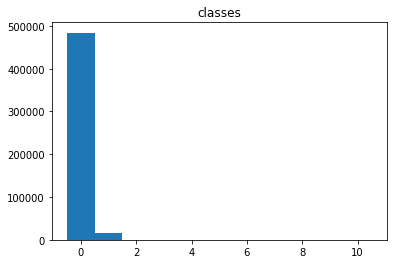

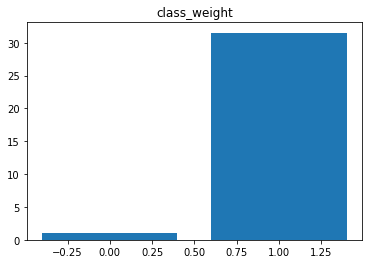

In [0]:
def get_class_weight(classes, exp=1):
    '''
    Weight of the class is inversely proportional to the population of the class.
    There is an exponent for adding more weight.
    '''
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    
    return class_weight

class_weight = get_class_weight(y)
print('class_weight=', class_weight)
plt.figure()
plt.title('classes')
plt.hist(y, bins=np.arange(12)-0.5)
plt.figure()
plt.title('class_weight')
plt.bar(np.arange(11), class_weight)
plt.title('class_weight')

Reading test data

In [0]:
print('Reading data...')
kal_td = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean_kalman.csv')
td = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean.csv')
# td = td[B_SIZE:2*B_SIZE]
# td.reset_index(inplace=True)
# td.drop('index', axis=1, inplace=True)
    
print('Feature engineering...')
kal_tdf = divide_and_add_features(td['signal'])
tdf = divide_and_add_features(td['signal'])

feats= []
for feat in kal_tdf.columns :
  feats.append('kal_' + feat)
kal_tdf.columns = feats

tdf = pd.concat([tdf, kal_tdf], axis=1) 

Reading data...


  0%|          | 0/4 [00:00<?, ?it/s]

Feature engineering...


100%|██████████| 4/4 [00:17<00:00,  4.37s/it]


In [0]:
tdf = reduce_mem_usage(tdf)
tdf

Mem. usage decreased from 3158.57 Mb to 801.09 Mb (74.6% reduction)


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,kal_roll_mean_100,kal_roll_std_100,kal_roll_min_100,kal_roll_max_100,kal_roll_range_100,kal_roll_median_100,kal_roll_mean_500,kal_roll_std_500,kal_roll_min_500,kal_roll_max_500,kal_roll_range_500,kal_roll_median_500,kal_roll_mean_1000,kal_roll_std_1000,kal_roll_min_1000,kal_roll_max_1000,kal_roll_range_1000,kal_roll_median_1000,kal_ewm_mean_5,kal_ewm_std_5,kal_ewm_mean_10,kal_ewm_std_10,kal_ewm_mean_50,kal_ewm_std_50,kal_ewm_mean_100,kal_ewm_std_100,kal_ewm_mean_500,kal_ewm_std_500,kal_ewm_mean_1000,kal_ewm_std_1000,kal_signal_shift_pos_1,kal_signal_shift_neg_1,kal_signal_shift_pos_2,kal_signal_shift_neg_2,kal_signal_shift_pos_3,kal_signal_shift_neg_3,kal_signal_mfcc_128,kal_signal_mfcc_256,kal_signal_mfcc_512,kal_signal_mfcc_1024
0,-0.178345,-0.013306,0.006302,0.007259,-0.006622,-0.178345,-0.176758,-0.178345,-0.177002,-0.178345,-0.177612,-0.178345,-0.178101,-0.178345,-0.178345,-0.178345,-0.178467,-0.178345,-0.178345,-0.178345,-0.178345,-0.178345,-0.178345,-0.178345,-0.178345,0.000000,-0.001605,-0.000000,-0.001264,0.000000,-0.000634,0.000000,-0.000104,0.000000,0.000083,0.000000,0.000047,0.000000,0.000010,0.000000,...,-0.179321,0.015549,-0.210083,-0.151001,0.059082,-0.180298,-0.180664,0.017685,-0.228638,-0.132935,0.095642,-0.180908,-0.181519,0.017014,-0.228638,-0.132935,0.095642,-0.181030,-0.178345,0.000000,-0.178345,0.000000,-0.178345,0.000000,-0.178345,0.000000,-0.178345,0.000000,-0.178345,0.000000,0.000000,-0.191650,0.000000,-0.192383,0.000000,-0.164062,-114.5000,-153.000,-190.625,-229.375
1,-0.191650,-0.007008,0.013557,0.000639,-0.009293,-0.178589,-0.176880,-0.178711,-0.177246,-0.178833,-0.177856,-0.179077,-0.178467,-0.179443,-0.178955,-0.179932,-0.179321,-0.180786,-0.179932,-0.181763,-0.181519,-0.183105,-0.184326,-0.185059,-0.188599,-0.013100,-0.014809,-0.012978,-0.014404,-0.012779,-0.013657,-0.012466,-0.012947,-0.011986,-0.012505,-0.011276,-0.012032,-0.010246,-0.010773,-0.008812,...,-0.179443,0.015404,-0.210083,-0.151001,0.059082,-0.180908,-0.180786,0.017670,-0.228638,-0.132935,0.095642,-0.180908,-0.181641,0.017014,-0.228638,-0.132935,0.095642,-0.181152,-0.186401,0.009407,-0.185669,0.009407,-0.185181,0.009407,-0.185059,0.009407,-0.185059,0.009407,-0.185059,0.009407,-0.178345,-0.192383,0.000000,-0.164062,0.000000,-0.176025,-114.5000,-153.000,-190.625,-229.375
2,-0.192383,0.013809,0.007580,-0.011322,-0.003742,-0.178955,-0.177002,-0.179321,-0.177368,-0.179810,-0.177979,-0.180542,-0.178833,-0.181519,-0.179321,-0.182861,-0.179565,-0.184692,-0.179810,-0.187012,-0.180786,-0.189453,-0.182617,-0.192017,-0.185181,-0.013397,-0.015419,-0.013023,-0.014969,-0.012436,-0.014153,-0.011551,-0.013374,-0.010246,-0.012955,-0.008430,-0.012695,-0.006081,-0.011932,-0.003325,...,-0.179321,0.015259,-0.210083,-0.151001,0.059082,-0.180298,-0.180786,0.017685,-0.228638,-0.132935,0.095642,-0.180908,-0.181519,0.017014,-0.228638,-0.132935,0.095642,-0.181030,-0.189209,0.007057,-0.188354,0.007500,-0.187622,0.007820,-0.187500,0.007858,-0.187500,0.007889,-0.187500,0.007896,-0.191650,-0.164062,-0.178345,-0.176025,0.000000,-0.172729,-114.5000,-153.000,-190.625,-229.375
3,-0.164062,0.008148,-0.009087,-0.006847,0.007591,-0.178955,-0.177002,-0.179199,-0.177490,-0.179688,-0.178223,-0.180298,-0.178955,-0.181030,-0.179443,-0.181763,-0.179321,-0.182373,-0.178711,-0.182495,-0.177856,-0.181396,-0.

**MLP MODEL**

In [0]:
tdf = tdf[0:B_SIZE]

In [0]:
tdf

,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,kal_roll_mean_100,kal_roll_std_100,kal_roll_min_100,kal_roll_max_100,kal_roll_range_100,kal_roll_median_100,kal_roll_mean_500,kal_roll_std_500,kal_roll_min_500,kal_roll_max_500,kal_roll_range_500,kal_roll_median_500,kal_roll_mean_1000,kal_roll_std_1000,kal_roll_min_1000,kal_roll_max_1000,kal_roll_range_1000,kal_roll_median_1000,kal_ewm_mean_5,kal_ewm_std_5,kal_ewm_mean_10,kal_ewm_std_10,kal_ewm_mean_50,kal_ewm_std_50,kal_ewm_mean_100,kal_ewm_std_100,kal_ewm_mean_500,kal_ewm_std_500,kal_ewm_mean_1000,kal_ewm_std_1000,kal_signal_shift_pos_1,kal_signal_shift_neg_1,kal_signal_shift_pos_2,kal_signal_shift_neg_2,kal_signal_shift_pos_3,kal_signal_shift_neg_3,kal_signal_mfcc_128,kal_signal_mfcc_256,kal_signal_mfcc_512,kal_signal_mfcc_1024
0,-0.178345,-0.013306,0.006302,0.007259,-0.006622,-0.178345,-0.176758,-0.178345,-0.177002,-0.178345,-0.177612,-0.178345,-0.178101,-0.178345,-0.178345,-0.178345,-0.178467,-0.178345,-0.178345,-0.178345,-0.178345,-0.178345,-0.178345,-0.178345,-0.178345,0.000000,-0.001605,-0.000000,-0.001264,0.000000,-0.000634,0.000000,-0.000104,0.000000,0.000083,0.000000,0.000047,0.000000,0.000010,0.000000,...,-0.179321,0.015549,-0.210083,-0.151001,0.059082,-0.180298,-0.180664,0.017685,-0.228638,-0.132935,0.095642,-0.180908,-0.181519,0.017014,-0.228638,-0.132935,0.095642,-0.181030,-0.178345,0.000000,-0.178345,0.000000,-0.178345,0.000000,-0.178345,0.000000,-0.178345,0.000000,-0.178345,0.000000,0.000000,-0.191650,0.000000,-0.192383,0.000000,-0.164062,-114.50,-153.000,-190.625,-229.375
1,-0.191650,-0.007008,0.013557,0.000639,-0.009293,-0.178589,-0.176880,-0.178711,-0.177246,-0.178833,-0.177856,-0.179077,-0.178467,-0.179443,-0.178955,-0.179932,-0.179321,-0.180786,-0.179932,-0.181763,-0.181519,-0.183105,-0.184326,-0.185059,-0.188599,-0.013100,-0.014809,-0.012978,-0.014404,-0.012779,-0.013657,-0.012466,-0.012947,-0.011986,-0.012505,-0.011276,-0.012032,-0.010246,-0.010773,-0.008812,...,-0.179443,0.015404,-0.210083,-0.151001,0.059082,-0.180908,-0.180786,0.017670,-0.228638,-0.132935,0.095642,-0.180908,-0.181641,0.017014,-0.228638,-0.132935,0.095642,-0.181152,-0.186401,0.009407,-0.185669,0.009407,-0.185181,0.009407,-0.185059,0.009407,-0.185059,0.009407,-0.185059,0.009407,-0.178345,-0.192383,0.000000,-0.164062,0.000000,-0.176025,-114.50,-153.000,-190.625,-229.375
2,-0.192383,0.013809,0.007580,-0.011322,-0.003742,-0.178955,-0.177002,-0.179321,-0.177368,-0.179810,-0.177979,-0.180542,-0.178833,-0.181519,-0.179321,-0.182861,-0.179565,-0.184692,-0.179810,-0.187012,-0.180786,-0.189453,-0.182617,-0.192017,-0.185181,-0.013397,-0.015419,-0.013023,-0.014969,-0.012436,-0.014153,-0.011551,-0.013374,-0.010246,-0.012955,-0.008430,-0.012695,-0.006081,-0.011932,-0.003325,...,-0.179321,0.015259,-0.210083,-0.151001,0.059082,-0.180298,-0.180786,0.017685,-0.228638,-0.132935,0.095642,-0.180908,-0.181519,0.017014,-0.228638,-0.132935,0.095642,-0.181030,-0.189209,0.007057,-0.188354,0.007500,-0.187622,0.007820,-0.187500,0.007858,-0.187500,0.007889,-0.187500,0.007896,-0.191650,-0.164062,-0.178345,-0.176025,0.000000,-0.172729,-114.50,-153.000,-190.625,-229.375
3,-0.164062,0.008148,-0.009087,-0.006847,0.007591,-0.178955,-0.177002,-0.179199,-0.177490,-0.179688,-0.178223,-0.180298,-0.178955,-0.181030,-0.179443,-0.181763,-0.179321,-0.182373,-0.178711,-0.182495,-0.177856,-0.181396,-0.176514

In [0]:
def create_mpl(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(150, activation='relu')(X_input)
    X = L.Dense(150, activation='relu')(X)
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(25, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)

    # X = L.Dense(150, activation='LeakyReLU')(X_input)
    # X = L.Dense(150, activation='LeakyReLU')(X)
    # X = L.Dense(125, activation='LeakyReLU')(X)
    # X = L.Dense(75, activation='LeakyReLU')(X)
    # X = L.Dense(50, activation='LeakyReLU')(X)
    # X = L.Dense(25, activation='LeakyReLU')(X)
    # X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model


In [0]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

# K-Fold with MLP.

In [0]:
from sklearn.model_selection import StratifiedKFold
i=1;
n_fold = 4 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],11))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print(i,"*******th fold**************")
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    mlp = create_mpl(X_train[0].shape)
    mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    mlp.fit(x=X_train, y=y_train, epochs=50, batch_size=1024, class_weight=class_weight)
    pred = mlp.predict(X_valid)
    pred = np.argmax(pred,axis=-1)
    score = f1_score_calc(y_valid, pred)
    print(score)
    #scores.append(score)
    y_pred = mlp.predict(tdf) 
    prediction += y_pred
    i = i+1

prediction /= n_fold
#print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))



In [0]:
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv')
sub['open_channels'] =  np.argmax(prediction, axis=-1)

sub.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/4_fold_mlp.csv', index=False, float_format='%.4f')
sub.head(10)



0          0
1          0
2          0
3          0
4          0
          ..
4999995    7
4999996    7
4999997    8
4999998    9
4999999    9
Name: open_channels, Length: 5000000, dtype: int64

In [0]:

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
i=1;
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],1))

params = {'boosting_type': 'gbdt',
          'metric': 'rmse',
          'objective': 'regression',
          'n_jobs': -1,
          'seed': 236}
          # 'num_leaves': 280,
          # 'learning_rate': 0.026623466966581126,
          # 'max_depth': 73,
          # 'lambda_l1': 2.959759088169741,
          # 'lambda_l2': 1.331172832164913,
          # 'bagging_fraction': 0.9655406551472153,
          # 'bagging_freq': 9,
          # 'colsample_bytree': 0.6867118652742716}

oof_pred = np.zeros(len(X))
# y_pred = np.zeros(shape=(tdf.shape[0], 1))
y_pred = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_valid, y_valid)
    
    model = lgb.train(params, train_set, num_boost_round = 10000, early_stopping_rounds = 50, 
                      valid_sets = [train_set, val_set], verbose_eval = 100)
    
    oof_pred[valid_index] = model.predict(X_valid)
    # y_pred += model.predict(tdf) / folds.n_splits
    y_pred.append(model.predict(tdf))
    # break
    
rmse_score = np.sqrt(metrics.mean_squared_error(y, oof_pred))
# want to clip and then round predictions (you can get a better performance using optimization to found the best cuts)
oof_pred = np.round(np.clip(oof_pred, 0, 10)).astype(int)
round_y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)
f1 = metrics.f1_score(y, oof_pred, average = 'macro')
print(f'Our oof rmse score is {rmse_score}')
print(f'Our oof macro f1 score is {f1}')


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.00749173	valid_1's rmse: 0.0158035
Early stopping, best iteration is:
[66]	training's rmse: 0.00840952	valid_1's rmse: 0.0157424
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[47]	training's rmse: 0.00928134	valid_1's rmse: 0.0171605
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.00731718	valid_1's rmse: 0.0158073
Early stopping, best iteration is:
[59]	training's rmse: 0.00856676	valid_1's rmse: 0.0156473
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.00759491	valid_1's rmse: 0.0146355
Early stopping, best iteration is:
[52]	training's rmse: 0.00958554	valid_1's rmse: 0.0144005
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.0075243	valid_1's rmse: 0.0151289
Early stopping, best iteration is:
[69]	training's rmse: 0.00834047	valid_1

In [0]:
pred_1= model.predict(df1)

In [0]:
pred_1 = np.round(np.clip(pred_1, 0, 10)).astype(int)
pred_1

array([0, 0, 0, ..., 0, 1, 0])

In [0]:
print(metrics.f1_score(y1, pred_1, average = 'macro'))

0.9967963477249301


In [0]:

for i in range(10):
  f1 = metrics.f1_score(y[i*B_SIZE:(i+1)*B_SIZE], oof_pred[i*B_SIZE:(i+1)*B_SIZE], average = 'macro')
  print(f'Our oof macro f1 score is {f1}')

Our oof macro f1 score is 0.6649656885364087
Our oof macro f1 score is 0.9970056217636767
Our oof macro f1 score is 0.9969067868530473
Our oof macro f1 score is 0.7891488617467105
Our oof macro f1 score is 0.7823361972562708
Our oof macro f1 score is 0.9723734421381471
Our oof macro f1 score is 0.9967995300257302
Our oof macro f1 score is 0.7690354609089181
Our oof macro f1 score is 0.971922489440832
Our oof macro f1 score is 0.8575170734701872


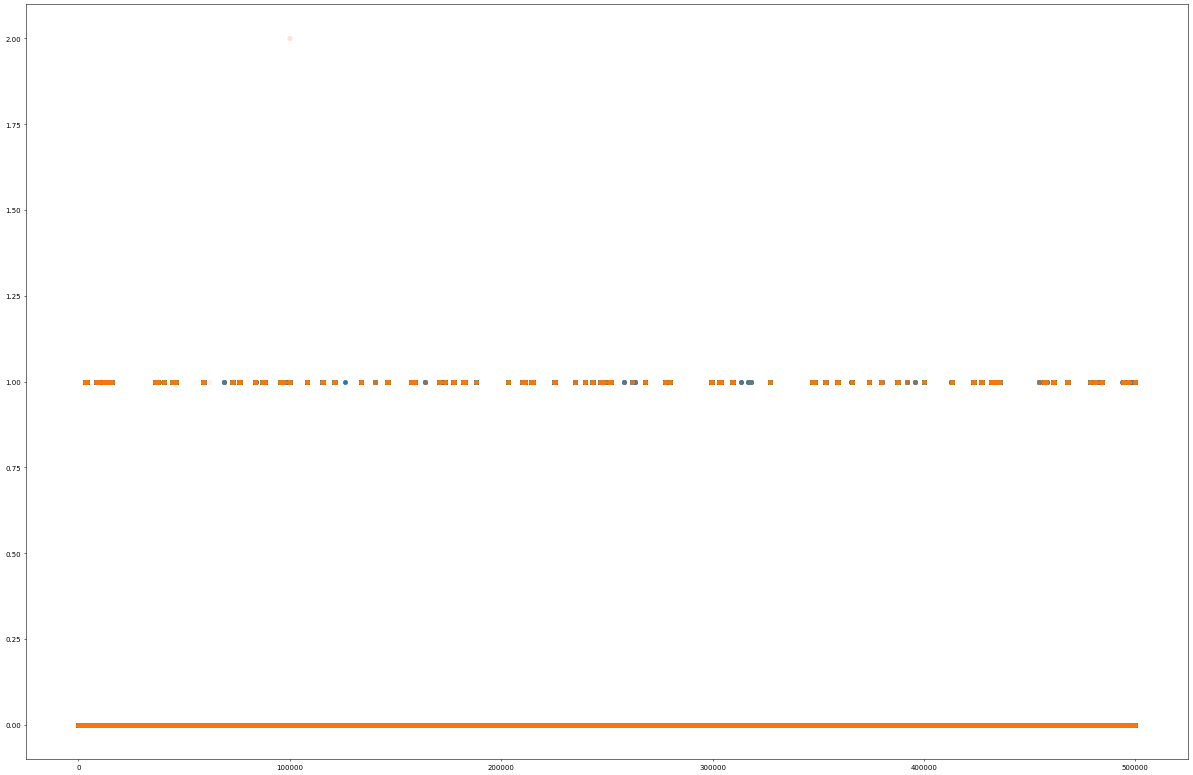

In [0]:
plt.figure(figsize=(30, 20), dpi=50)
x = np.arange(B_SIZE)
plt.scatter(x, y[1*B_SIZE:(1+1)*B_SIZE])
plt.scatter(x, oof_pred[1*B_SIZE:(1+1)*B_SIZE], alpha=0.1)

In [0]:
for i in range(len(y_pred)):
  if i == 0:
    predpred = y_pred[i] / folds.n_splits
  else:
    predpred += y_pred[i] / folds.n_splits

round_y_pred = np.round(np.clip(predpred, 0, 10)).astype(int)

submission = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv')

submission['open_channels'] = round_y_pred
submission.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission.csv', index = False, float_format='%.4f')
submission.head(20)